# Boosting

In the present section a simple classifier and an adaptive boosting model will be built from scratch in order to extend the work done in `Default of Credit Card Clients`with Random Forests. 

We will build a classification that attempts to predict whether or not a particular census respondant has an income of more or less than $50,000.  

The data is found on [**`Census Income Data`**](https://archive.ics.uci.edu/ml/datasets/census+income) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html).

The simple Classifier we will review how to find the potential splits in data, the best splits according to the choosen entropy and creating binary predictions for a given split. 

The Adaptive Boosting algorithm creates weights, calculates epsilon and Alpha and updates theweights. This algorithm will be used to create predictions on Census Data.  

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

# Building a Simple Binary Tree Classifier

The structure of this pseudo-code mimics the structure of the `sklearn` classifiers in that it creates "fit" and "predict" methods.  

In [3]:
class Simple_Binary(object):
    
    def __init__(self):
        
        pass
    
    def fit(self, X,y):

    
    def predict(self, X):
        
        pass

Analogously to `sklearn`, our `.fit()` and `.predict()` methods will be written as independent `simple_binary_tree_fit()` and `simple_binary_tree_predict()` functions.

In [4]:
def simple_binary_tree_fit(X,y):
    
    # "best_split" = (col_number, split_value, entropy)
    best_split = (-1,-1,1)
    
    # loop through each column in X
    for col_idx, col in enumerate(X.T):
        
        # Find potential split values within column using `find_splits(col)`
        splits = find_splits(col) 
        
        # For each split, calculate entropy
        for s in splits:
            ent = ent_from_split(col, s, y) 
            
            # Check if calculated entropy is less than previous "best"
            if ent < best_split[2]:
                best_split = (col_idx, s, ent)
    
    # "best split" has been found.
    # create "left" and "right" predictions for the best_split
    # "left" predictions is for when `observation` <= `split_value`
    # "right" prediction is for when `observation` > `split_value`
    # Each prediction will either be 1 for "True" or 0 for "False"
    
    left_pred, right_pred = pred_from_split(X, y, *best_split[:2]) 
    
    col_idx, split_value = best_split[:2]
    
    # return:
    # - the index of the column to split on.
    # - the value to split that column on
    # - the prediction for rows with observations in that column less than or equal to the split
    # - the prediction for rows with observations in that column greater than the split
    
    return col_idx, split_value, left_pred, right_pred

In [5]:
def find_splits(col):
    
    # Sort list of unique values
    srt = np.sort(np.unique(col))

    # Shift values by inserting value at begining, also deleting final value
    shift = np.delete(np.insert(srt,0,0), -1)
    
    # Take the difference divided by two of the sorted and shifted list, and remove initial placeholder
    # Add to the sorted list with final element removed
    splits = np.delete(srt,-1) + np.delete((srt-shift)/2,0)
    
    splits = np.array()
    
    return splits

## Entropy for binary classification at binary split

The entropy at a node containing only two classes is calculated by, 

$$Entropy(node) = -p_{class1}*log_2(p_{class1}) + -p_{class2}*log_2(p_{class2})$$  

Suppose a node contains the observations [1,0,1,1]. Then,   

$Entropy(node) = -p_{class1}*log_2(p_{class1}) + -p_{class2}*log_2(p_{class2})$  

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = -.75*log_2(.75) + -.25*log_2(.25)$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = .311 + .5$

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \approx .811$  


This calculation is already programmed into the supplied `entropy()` function below.  

In [6]:
def entropy(class1_n, class2_n):
    
    # If all of one category, log2(0) does not exist,
    # and entropy = 0
    if (class1_n == 0) or (class2_n == 0):
        return 0

    # Find total number of observations 
    total = class1_n + class2_n

    # find proportion of both classes
    class1_proprtion = class1_n/total
    class2_proportion = class2_n/total

    # implement entropy function
    return  sum([-1 * prop * np.log2(prop)
                 for prop in [class1_proprtion, class2_proportion] ])

print(entropy(3,1))

0.8112781244591328


The entropy of a split is, 
$$Entropy(split) = p_{node1} * Entropy(node1)+ p_{node2}* Entropy(node2)$$  


Where $p_{node}$ is the proportion of observations at that node

Suppose:  
Node 1 contains the observations - [1,0,1,1]  
Node 2 contains the observations - [0,0,0,1,1,0]

Then:  
$Entropy(split) = p_{node1} * Entropy(node1)+ p_{node2}* Entropy(node2)$  

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ = .4 *Entropy(node1) + .6 * Entropy(node2)$

--------------------------------  

For our purposes, the two classes in each node will be defined by:
1. Observations with values less than or equal to the split value  
2. Observations with values greater than the split value.

In [7]:
def ent_from_split(col, split_value, labels):
    
    # Define entropy function
    def entropy(class1_n, class2_n):
        
        # If all of one category, log2(0) does not exist,
        # and entropy = 0
        if (class1_n == 0) or (class2_n == 0):
            return 0
        
        # Find total number of observations
        total = class1_n + class2_n
        
        # find proportion of both classes
        class1_proprtion = class1_n/total
        class2_proportion = class2_n/total
        
        # implement entropy function
        return sum([-1 * prop * np.log2(prop)
                    for prop in [class1_proprtion, class2_proportion] ])
    
    # Helper function to find number in each class at each node.
    def node_classes(col, split_value, labels):
        
        # subset labels by observations that are <= / > the split value
        le_node = labels[col <= split_value]
        g_node = labels[col > split_value]
        
        # count members of each class at each node
        # c1 corresponds to "1's"
        # c2 corresponds to "0's
        le_c1 = np.count_nonzero(le_node)
        le_c2 = len(le_node) - le_c1
        g_c1 = np.count_nonzero(g_node)
        g_c2 = len(g_node) - g_c1
        
        return le_c1, le_c2, g_c1, g_c2
    
    # Find number in each class at both nodes
    le_c1, le_c2, g_c1, g_c2 = node_classes(col, split_value, labels)
    
    # calculate proportion of total at each node
    total = len(col)
    p_g = (g_c1 + g_c2) / total
    p_le = (le_c1+ le_c2) / total
    
    # implement entropy calculation
    return (p_le * entropy(le_c1, le_c2)) + (p_g * entropy(g_c1, g_c2))

In [8]:
def pred_from_split(X, y, col_idx, split_value):
    
    def node_classes(col, split_value, labels):
        
        # subset labels by observations that are <= / > the split value
        le_node = labels[col <= split_value]
        g_node = labels[col > split_value]
        
        # count members of each class at each node
        # c1 corresponds to "1's"
        # c2 corresponds to "0's
        le_c1 = np.count_nonzero(le_node)
        le_c2 = len(le_node) - le_c1
        g_c1 = np.count_nonzero(g_node)
        g_c2 = len(g_node) - g_c1
        
        return le_c1, le_c2, g_c1, g_c2
    
    # Return count of each class at each node using helper function
    le_c1, le_c2, g_c1, g_c2 = node_classes(X[:,col_idx], split_value, y)
    
    def pred_for_node(cl1, cl2):
        
        # if more of class 1 than class 2, return True (1)
        if cl1 > cl2: return True
        # if more of class 2 than class 1, return False (0)
        elif cl1 < cl2: return False
        # if equal number, return None
        else: return None
        
    # Create intial predictions
    left = pred_for_node(le_c1,le_c2)
    right = pred_for_node(g_c1, g_c2)

    # Check predictions for ties
    # Check to see if one of the predictions came back as "None"
    if ((right == None) or (left == None)) and (right != left):
        if left == None:
            left = not right
        else:
            right = not left
            
    # Check to see if both predictions came back as "None"
    if (right == None) and (left == None):
        right = True; left = True
        
    # Convert predictions to integers, and return as tuple
    return (int(left), int(right))

In [9]:
def simple_binary_tree_predict(X, col_idx, split_value, left_pred, right_pred):

    # take out column
    col = X[:,col_idx]
    
    # If both predictions are same, return all that prediction
    if left_pred == right_pred:
        preds = np.ones(len(col))
        preds *= int(left_pred)
        
    # if left_pred ( == 1) return 1's where col is <= split
    elif left_pred:
        preds = (col<= split_value)*1
    # otherwise, 1's where col is > split
    else:
        preds = (col >split_value)*1

    return preds

At this point, we have a functioning binary-tree classifier that can be fit on data, and then given that fit, make predictions on out-of-sample data.  

Our Adaptive Boosting algorithm's prediction for out of sample data will be,   

$$f_{boost}(x_0) = sign(\sum_{t=1}^T\alpha_tf_t(X_0))$$  

where alpha is
$$\alpha_t = \frac12ln(\frac{1-\epsilon_t}{\epsilon_t})$$  

epsilon is,   

$$\epsilon_t = \sum_{i=1}^nw_t(i)\mathbb{1}\{y_i\ne f_t(x_i)\}$$  

and all weights starts at$\frac1n$.   

The weights are update by, 
$$w_{t+1}(i) = \frac{\hat{w}_{t+1}(i)}{\sum_j\hat{w}_{t+1}(j)}$$  

where, 
$$\hat{w}_{t+1}(i) = w_t(i)e^{-\alpha_ty_if_t(x_i)}$$.

While we could use the `simple_binary_tree` functions created above, in the interest of speed, we will use sklearn's `DecisionTreeClassifier` as a the simple predictor to boost.

In [11]:
def simple_tree():
    return DecisionTreeClassifier(criterion = 'entropy', max_depth= 1)

We will try it in a sample dataset

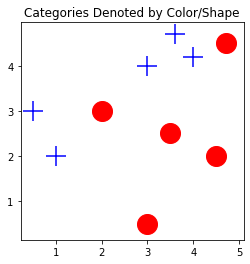

df:
      x    y  classification
0  0.5  3.0               1
1  1.0  2.0               1
2  3.0  0.5              -1
3  2.0  3.0              -1
4  3.0  4.0               1
5  3.5  2.5              -1
6  3.6  4.7               1
7  4.0  4.2               1
8  4.5  2.0              -1
9  4.7  4.5              -1 

threshold: 1.5 feature: 0
threshold: 3.3499999046325684 feature: 1

tree1 predictions on all elements: [1 1 0 0 0 0 0 0 0 0]
tree2 predictions on all elements: [0 0 0 0 1 0 1 1 0 1]

Entropy of different splits for observations 5-9
Col 1, @ 3.35: 0.5509775004326937
Col 0, # 4.25: 0.5509775004326937


In [12]:
# Example dataset
pts = [[.5, 3,1],[1,2,1],[3,.5,-1],[2,3,-1],[3,4,1],
 [3.5,2.5,-1],[3.6,4.7,1],[4,4.2,1],[4.5,2,-1],[4.7,4.5,-1]]

df = pd.DataFrame(pts, columns = ['x','y','classification'])

# Plotting by category
b = df[df.classification ==1]
r = df[df.classification ==-1]
plt.figure(figsize = (4,4))
plt.scatter(b.x, b.y, color = 'b', marker="+", s = 400)
plt.scatter(r.x, r.y, color = 'r', marker = "o", s = 400)
plt.title("Categories Denoted by Color/Shape")
plt.show()


print("df:\n",df, "\n")

# split  X and y
X = df[['x','y']]

# Change from -1 and 1 to 0 and 1
y = np.array([1 if x == 1 else 0 for x in df['classification']])

### Split data in half
X1 = X.iloc[:len(X.index)//2, :]
X2 = X.iloc[len(X.index)//2:, :]

y1 = y[:len(y)//2]
y2 = y[len(X)//2:]


# Fit classifier to both sets of data, save to dictionary:

tree_dict = {}

tree1 = simple_tree()
tree1.fit(X1,y1)

print("threshold:", tree1.tree_.threshold[0], "feature:", tree1.tree_.feature[0])

# made up alpha, for example
alpha1 = .6
tree_dict[1] = (tree1, alpha1)

tree2 = simple_tree()
tree2.fit(X2,y2)
print("threshold:", tree2.tree_.threshold[0], "feature:" ,tree2.tree_.feature[0])

# made up alpha, again.
alpha2 = .35

tree_dict[2] = (tree2, alpha2)

# Create predictions using trees stored in dictionary
print("\ntree1 predictions on all elements:", tree_dict[1][0].predict(X))
print("tree2 predictions on all elements:", tree_dict[2][0].predict(X))

# Showing Ent
print("\nEntropy of different splits for observations 5-9")
print("Col 1, @ 3.35:", ent_from_split(X2.iloc[:,1].values,3.35, y2))
print("Col 0, # 4.25:", ent_from_split(X2.iloc[:,0].values, 4.25, y2))


# Bootstrapping

Taking a bootstrap sample in adaptive boosting requires selecting observation with pre-defined probabilities.  

In [13]:
select_from = list(range(5))
print("selecting from:", select_from, "\n")

### Implement 1/n weights (which is the np.random.choice default)
### Also note:
### replace = True (default, used for boot-strapping)
### size = len(array) - This will be the sample size used in our algorithms.

print("Equal Weights:\n",
    np.random.choice(select_from,
                size = len(select_from),
                replace = True,
                p = np.array([.2,.2,.2,.2,.2,])
                )
)

### Now, using uneven weights

print("\nWeights of [.9,.05,.03,.02,0]:\n",
    np.random.choice(select_from,
                size = len(select_from),
                p = np.array([.9,.05,.03,.02,0]))
)

selecting from: [0, 1, 2, 3, 4] 

Equal Weights:
 [1 2 2 1 3]

Weights of [.9,.05,.03,.02,0]:
 [0 0 0 0 0]


# Building Adaptive Boosting

In [14]:
def simple_adaboost_fit(X,y, n_estimators):
    
    def simple_tree():
        return DecisionTreeClassifier(criterion = 'entropy', max_depth= 1)
    
    # Create default weights array where all are equal to 1/n
    weights = default_weights(len(y)) 
    
    est_dict = {}
    for i in range(n_estimators):
        
        # Create bootstrap sample
        bs_X, bs_y = boot_strap_selection(X, y, weights)
        
        mod = simple_tree()
        mod.fit(bs_X, bs_y)
        
        # Predicting on all values of X, NOT boot-strap
        preds = mod.predict(X)
        
        epsilon = calc_epsilon(y, preds, weights)
        alpha = calc_alpha(epsilon) 
        
        # Note that the i+1-th model will be keyed to the int i,
        # and will store a tuple of the fit model and the alpha value
        est_dict[i] = (mod, alpha)
        
        weights = update_weights(weights, alpha, y, preds) 
    
    return est_dict 

Create the default list of weights, a numpy array of length n with each value equal to 1/n

In [15]:
def default_weights(n):
    return np.ones(n)*(1/n)

The "`boot_strap_selection`" algorithm creates a boot-strap sample given the passed-in weights.  

In [16]:
def boot_strap_selection(X, y, weights):
    
    # Take random sample of indicies, with replacement
    bss_indicies = np.random.choice(range(len(y)), size = len(y), p = weights)
    
    # Subset arrays with indicies
    return X[bss_indicies,:], y[bss_indicies]

### Example of use
X = np.array([[1,1],[2,2],[3,3],[4,4],[5,5]])
y = np.array([1,0,1,0,1])
weights = np.array([.35,.1,.1,.35,.1])

print(boot_strap_selection(X,y, weights))    

(array([[1, 1],
       [5, 5],
       [2, 2],
       [5, 5],
       [3, 3]]), array([1, 1, 0, 1, 1]))


Calculating Epsilon
 
$$\epsilon_t = \sum_{i=1}^nw_t(i)\mathbb{1}\{y_i\ne f_t(x_i)\}$$  

In [17]:
def calc_epsilon(y_true, y_pred, weights):

    # subset weights taking only values where y_true != y_pred
    return weights[y_true != y_pred].sum()

Calculating alpha.

$$\alpha_t = \frac12ln(\frac{1-\epsilon_t}{\epsilon_t})$$  

In [18]:
def calc_alpha(epsilon):
    
    if epsilon == 0:
        return np.inf
    return .5 * np.log(((1-epsilon)/epsilon))

Updating weights

To update weights, 
$$w_{t+1}(i) = \frac{\hat{w}_{t+1}(i)}{\sum_j\hat{w}_{t+1}(j)}$$  

where, 
$$\hat{w}_{t+1}(i) = w_t(i)e^{-\alpha_ty_if_t(x_i)}$$.

In [19]:
def update_weights(weights, alpha, y_true, y_pred):
    
    # helper function to convert target of 1's and 0's to 1's and -1's
    def target_for_weight_update(y):
        
        toRet = y.copy()
        toRet[toRet == 0] = -1
        
        return toRet
    
    # convert predictions and actual labels to 1's and -1's
    y = target_for_weight_update(y_true)
    pred = target_for_weight_update(y_pred)
    
    # implement weight update equation
    weights = weights * np.e**(-alpha*y*pred)
    
    # normalize weights by dividing by sum of all weights
    weights = weights / sum(weights)
    
    return weights

`simple_adaboost_fit()` returns a dictionary where the keys are 0 through n-1 where n is the `n_estimators` from the function signature.  

The values of the dictionaries are (model, alpha) where `model`is a `DecisionTreeClassifier`, and `alpha` is a float.  

---

Creating a Prediction from boosted trees. Our prediction will be, 

$$f_{boost}(x_0) = sign(\sum_{t=1}^T\alpha_tf_t(X_0))$$  

In [20]:
def predict(X, est_dict):
   
    fin_preds = np.zeros(X.shape[0])
    
    for k in est_dict:
        
        preds = est_dict[k][0].predict(X)
        preds[preds<1] = -1
        
        preds = preds *est_dict[k][1]
        fin_preds += preds

    fin_preds[fin_preds >= 0 ] = 1
    fin_preds[fin_preds <0] = 0
    
    return fin_preds

# Census Data

Now we implement the code to the [**`Census Income Data`**](https://archive.ics.uci.edu/ml/datasets/census+income) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.html).

In particular, this classification attempts to predict whether or not a particular census respondant has an income of more or less than $50,000.  
  
## The Data

In [21]:
col_names = [
"age", "workclass", "fnlwgt", "education",
"education-num", "marital-status", "occupation", "relationship",
"race", "sex", "capital-gain", "capital-loss", "hours-per-week",
"native-country", "income"
]

data_path = "adult.data"

data = pd.read_csv(data_path, header = None, names = col_names)
data.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


We take a subset of the data relevant for the prediction problem

In [22]:
cols = ["age", "workclass", "education-num", "occupation", "sex", "hours-per-week", "income"]
data = data[cols]
data.head()

,age,workclass,education-num,occupation,sex,hours-per-week,income
0,39,State-gov,13,Adm-clerical,Male,40,<=50K
1,50,Self-emp-not-inc,13,Exec-managerial,Male,13,<=50K
2,38,Private,9,Handlers-cleaners,Male,40,<=50K
3,53,Private,7,Handlers-cleaners,Male,40,<=50K
4,28,Private,13,Prof-specialty,Female,40,<=50K


Take a look at the data

In [23]:
data.describe(include = 'all')

,age,workclass,education-num,occupation,sex,hours-per-week,income
count,32561.000000,32561,32561.000000,32561,32561,32561.000000,32561
unique,NaN,9,NaN,15,2,NaN,2
top,NaN,Private,NaN,Prof-specialty,Male,NaN,<=50K
freq,NaN,22696,NaN,4140,21790,NaN,24720
mean,38.581647,NaN,10.080679,NaN,NaN,40.437456,NaN
std,13.640433,NaN,2.572720,NaN,NaN,12.347429,NaN
min,17.000000,NaN,1.000000,NaN,NaN,1.000000,NaN
25%,28.000000,NaN,9.000000,NaN,NaN,40.000000,NaN
50%,37.000000,NaN,10.000000,NaN,NaN,40.000000,NaN
75%,48.000000,NaN,12.000000,NaN,NaN,45.000000,NaN


## Exploratory Data Analysis

Lets look at the distributions of the counts of individuals as a function of the features

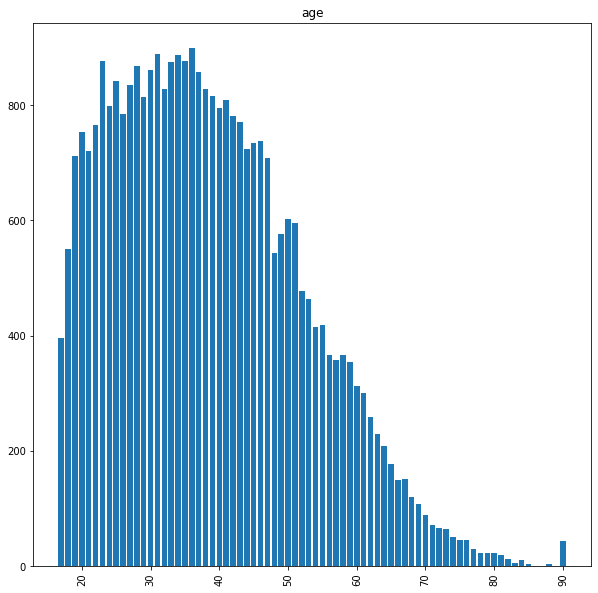

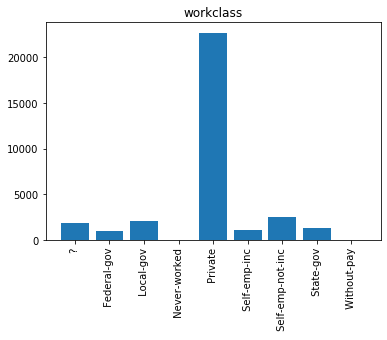

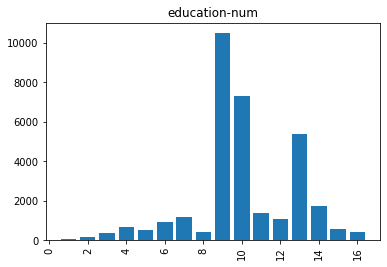

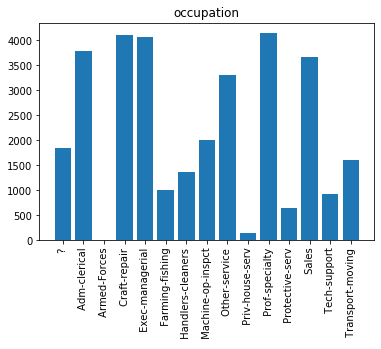

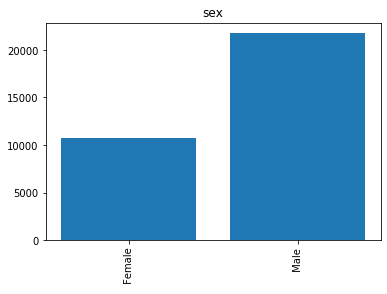

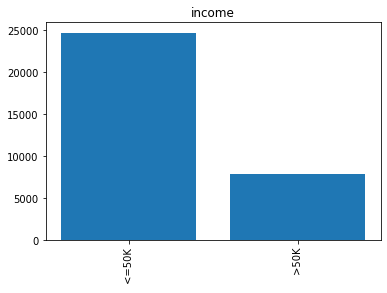

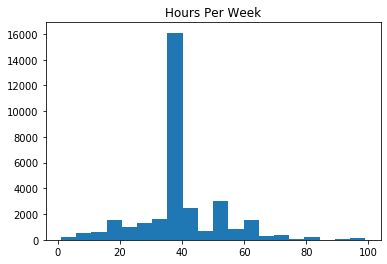

In [24]:
plt.figure(figsize=(10,10))

for i, col in enumerate(data.drop("hours-per-week", axis = 1)):
    d = data[col].value_counts().sort_index()
    plt.bar(d.index, d)
    plt.xticks(rotation = 90)
    plt.title(col)
    plt.show()

plt.hist(data['hours-per-week'], bins = 20);
plt.title("Hours Per Week");

The target variable of income over/under $50k is unbalanced. 

---

## Preprocessing

The following cells  demonstrates the functions used in preprocessing, concluding with the division of data into a training and testing sets, that are then preprocessed.  

### Dummy Variables

In the creation of dummy variables, the most frequently occuring class will be dropped as a way of avoiding multicollinearity.  


In [26]:
val_count = data['workclass'].value_counts()
print('All Value Counts:')
print(val_count)

top = val_count[0]
print("\nTop category:", top)

All Value Counts:
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

Top category: 22696


### One Hot Encoder  

Dummies will be created using `sklearn`'s `OneHotEncoder`.  The following cell demonstrates fitting and transforming data using the One Hot Encoder.

In [28]:
ex_df = pd.DataFrame(
    np.array([['b', 'a', 'c', 'a', 'c',], ["z","y","y","y","z"]]).T,
    columns = ["beg","end"],
    index = range(500,505))

test_df = pd.DataFrame(
    np.array([["c","b"],["y","y"]]).T,
    columns = ["beg","end"],
    index = [56,72])

print("Initial DataFrame:")
print(ex_df)

print("\nTest df")
print(test_df)

Initial DataFrame:
    beg end
500   b   z
501   a   y
502   c   y
503   a   y
504   c   z

Test df
   beg end
56   c   y
72   b   y


In [29]:
# Instantiate OneHotEncoder
ohe = OneHotEncoder(sparse = False)

# Fitting OHE with the "training" data
ohe.fit(ex_df)

# Transforming the "training" dat
tr_vals = ohe.transform(ex_df)

print("\nTransformed values")
print(tr_vals)

print("\nCategories")
print(ohe.categories_)

# Creating column names from `.categories_`
ohe_cats = np.concatenate(ohe.categories_)

# In creation of new df. Note the use of np.concatenate
final_df = pd.DataFrame(tr_vals, columns = ohe_cats)

print("\nFinal DataFrame")
print(final_df)

# Putting everything together to transform test data
print("\nTransformed test df")
print(pd.DataFrame(ohe.transform(test_df), columns= ohe_cats))


Transformed values
[[0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1.]]

Categories
[array(['a', 'b', 'c'], dtype=object), array(['y', 'z'], dtype=object)]

Final DataFrame
     a    b    c    y    z
0  0.0  1.0  0.0  0.0  1.0
1  1.0  0.0  0.0  1.0  0.0
2  0.0  0.0  1.0  1.0  0.0
3  1.0  0.0  0.0  1.0  0.0
4  0.0  0.0  1.0  0.0  1.0

Transformed test df
     a    b    c    y    z
0  0.0  0.0  1.0  1.0  0.0
1  0.0  1.0  0.0  1.0  0.0


### LabelEncoder

`sklearn`'s `LabelEncoder` will be used to transform our income variable from strings to 0s and 1s

In [31]:
# Create target Series
target_train = pd.Series(np.random.choice(data['income'].unique(), size = 10))
target_test = pd.Series(np.random.choice(data['income'].unique(), size = 5))
print("Target Train Series")
print(target_train)

print("\nTarget Test Series")
print(target_test)

Target Train Series
0      >50K
1      >50K
2     <=50K
3     <=50K
4      >50K
5      >50K
6     <=50K
7     <=50K
8      >50K
9      >50K
dtype: object

Target Test Series
0     >50K
1     >50K
2     >50K
3     >50K
4     >50K
dtype: object


In [32]:
# Instantiate encoder
le = LabelEncoder()

# Fit with training data
le.fit(target_train)

# Transform training and test data
trans_train = le.transform(target_train)
trans_test = le.transform(target_test)

print("Transformed training values")
print(trans_train)

print("\nTransformed test values")
print(trans_test)

print("\nLabelEncoder `.classes_`")
print(le.classes_)

Transformed training values
[1 1 0 0 1 1 0 0 1 1]

Transformed test values
[1 1 1 1 1]

LabelEncoder `.classes_`
[' <=50K' ' >50K']


### Define a custom preprocessing function

Using the processes demonstrated above, a function is created to preprocess the census data. The function is then used to create a training and testing dataset

In [33]:
def preprocess_census(X_train, X_test, y_train, y_test):

    # Hardcode variables which need categorical encoding
    to_encode = ["workclass", "occupation", "sex"]

    # Find top categories in categorical columns
    # Used for dropping majority class to prevent multi-colinearity
    top_categories = []

    for col in to_encode:
        top_categories.append(X_train[col].value_counts().index[0])

    # Create and fit one-hot encoder for categoricals
    OHE = OneHotEncoder(sparse = False)
    OHE.fit(X_train[to_encode])

    # Create and fit Label encoder for target
    LabEnc = LabelEncoder()
    LabEnc.fit(y_train)

    def create_encoded_df(X, to_encode = to_encode, OHE = OHE, top_categories = top_categories):
        # Return columns which need encoding.
        def return_encoded_cols(X, to_encode = to_encode, OHE = OHE, top_categories = top_categories):
            
            # Use onehotencoder to transform.
            # Use "categories" to name
            toRet = pd.DataFrame(OHE.transform(X[to_encode]), columns = np.concatenate(OHE.categories_))

            # Drop top_categories and return
            return toRet.drop(top_categories, axis = 1)

        # create encoded columns
        ret_cols = return_encoded_cols(X)

        # Drop columns that were encoded
        dr_enc = X.drop(to_encode, axis = 1)

        # Concatenate values
        # use index from original data
        # use combined column names
        return pd.DataFrame(np.concatenate([ret_cols.values, dr_enc.values],axis = 1),
                            index = dr_enc.index,
                            columns = list(ret_cols.columns) + list(dr_enc.columns))


    def encode_target(y, LabEnc = LabEnc):
        
        # Use label encoder, and supply with original index
        return pd.Series(LabEnc.transform(y), index= y.index)

    return create_encoded_df(X_train), create_encoded_df(X_test), encode_target(y_train), encode_target(y_test)

In [35]:
# Create training and testing sets; preprocess them.
target = data['income']
predictors = data.drop("income", axis = 'columns')

X_train, X_test, y_train, y_test = preprocess_census(*train_test_split(predictors, target, test_size = .2))

### Fitting Models to Data  

Creating predictions from your adaptive-boosted model.

In [41]:
d = simple_adaboost_fit(X_train.values.copy(), y_train.values.copy(), 50)
preds = predict(X_test, d)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4940
           1       0.64      0.46      0.54      1573

    accuracy                           0.81      6513
   macro avg       0.74      0.69      0.71      6513
weighted avg       0.79      0.81      0.80      6513



# `sklearn` Implementation of Adaptive Boosting

In [40]:
RF = RandomForestClassifier(n_estimators = 50)
RF.fit(X_train, y_train)

print("Random Forest:\n")
print(classification_report(y_test, RF.predict(X_test)))
ABC = AdaBoostClassifier(n_estimators = 50)
ABC.fit(X_train, y_train)
print("\nAdaBoost:\n")
print(classification_report(y_test, ABC.predict(X_test)))

Random Forest:

              precision    recall  f1-score   support

           0       0.84      0.88      0.86      4940
           1       0.57      0.48      0.52      1573

    accuracy                           0.79      6513
   macro avg       0.70      0.68      0.69      6513
weighted avg       0.78      0.79      0.78      6513


AdaBoost:

              precision    recall  f1-score   support

           0       0.85      0.93      0.88      4940
           1       0.67      0.47      0.55      1573

    accuracy                           0.82      6513
   macro avg       0.76      0.70      0.72      6513
weighted avg       0.80      0.82      0.80      6513



The precision and recall of the your custom Adaptive Boosting are very similar to the `sklearn` adaboost.

Notice the higher precision of the AdaBoost compared to the Random Forest